# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [ ]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os
import time
!pip install pytorch_metric_learning
from pytorch_metric_learning import miners, losses

print("Cuda:", torch.cuda.is_available())

     |████████████████████████████████| 92kB 3.7MB/s 
Cuda: True


In [ ]:
# Mount to drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


## Helper functions
Set of helper functions

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()


## Configuration Class
A simple class to manage configuration

In [ ]:
class Config():
    training_dir = F"/content/gdrive/My Drive/DTU - Speciale F2020/Siamese_Networks/data/campus2_training/"
    testing_dir = F"/content/gdrive/My Drive/DTU - Speciale F2020/Siamese_Networks/data/campus2_test/"
    train_batch_size = 32
    test_batch_size = 1
    train_number_epochs = 100

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [ ]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class

        while True:
            #keep looping till the same class image is found
            img1_tuple = random.choice(self.imageFolderDataset.imgs) 
            if img0_tuple[1]==img1_tuple[1] and img0_tuple[0]!=img1_tuple[0]:
                break

        while True:
            #keep looping till a different class image is found
            img2_tuple = random.choice(self.imageFolderDataset.imgs) 
            if img0_tuple[1] !=img2_tuple[1]:
                break

        while True:
            #keep looping till a different class image is found
            img3_tuple = random.choice(self.imageFolderDataset.imgs) 
            if img0_tuple[1] !=img3_tuple[1] and img2_tuple[1] !=img3_tuple[1]:
                break

        labels = [img0_tuple[1], img1_tuple[1], img2_tuple[1], img3_tuple[1]]

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img2 = Image.open(img2_tuple[0])
        img3 = Image.open(img3_tuple[0])
        #img0 = img0.convert("L")
        #img1 = img1.convert("L")
        #img2 = img2.convert("L")
        #img3 = img3.convert("L")

        #print("0:", img0_tuple)
        #print("1:", img1_tuple)
        #print("2:", img2_tuple)
        #print("3:", img3_tuple)
        #print(int(img1_tuple[1]!=img0_tuple[1]))

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)
            img2 = PIL.ImageOps.invert(img2)
            img3 = PIL.ImageOps.invert(img3)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)

        return img0, img1 , img2, img3, labels
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [ ]:
folder_dataset_train = dset.ImageFolder(root=Config.training_dir)
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)

In [ ]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                #transforms.RandomAffine((0,0), translate=(0.1,0.1), scale =  (1, 1.2)),
                                transforms.ColorJitter((0.5,2)),
                                transforms.Resize((275,134)),
                                transforms.RandomChoice([transforms.RandomCrop((200,100))
                                                        ,transforms.Resize((200,100))]),
                                transforms.ToTensor(),
                                #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                #transforms.RandomErasing(scale=(0.02, 0.2)),
                                ])

siamese_dataset_train = SiameseNetworkDataset(imageFolderDataset=folder_dataset_train,
                                        transform=transform,
                                        should_invert=False)

siamese_dataset_test = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((200,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data


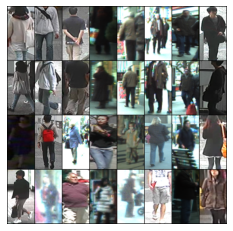

[1324 1472 1092 2411 2322 2331 2420 1656]
[1324 1472 1092 2411 2322 2331 2420 1656]
[ 402  999 2337 2121 2434 2350 2414  907]
[1087 2374 2247 2379 2338  741 2382  954]


In [ ]:
vis_dataloader = DataLoader(siamese_dataset_train,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1], example_batch[2], example_batch[3]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[4][0].numpy())
print(example_batch[4][1].numpy())
print(example_batch[4][2].numpy())
print(example_batch[4][3].numpy())

## Neural Net Definition


In [ ]:
class QdrupletNetwork(nn.Module):
    def __init__(self):
        super(QdrupletNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout(p=0.05),

            nn.Conv2d(4, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout(p=0.05),

            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.Dropout(p=0.05),

            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Dropout(p=0.05),

            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout(p=0.05),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8 * 100 * 50, 500),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.05),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.05),

            nn.Linear(500, 10))

    def forward(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

## Quadruplet Loss

In [ ]:
class QaudrupletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin1, margin2):
        super(QaudrupletLoss, self).__init__()
        self.margin1 = margin1
        self.margin2 = margin2

    def forward(self, anchor, positive, negative1, negative2, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative1).pow(2).sum(1)  # .pow(.5)
        distance_complet_negative = (negative2 - negative1).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin1) + F.relu(distance_positive - distance_complet_negative + self.margin2)
        return losses.mean() if size_average else losses.sum()

## Test function

In [ ]:
def test(net, dataloader, print_res = True):
  index = 0
  positive = 0
  for i, data in enumerate(test_dataloader,0):
      img0, img1 , img2, img3, labels = data
      x = torch.cat((img0, img1, img2, img3),0)
      x = x.cuda()
      embeddings = net(x)
      
      batch_size = int(embeddings.shape[0]/3)

      euclidean_distance1 = F.pairwise_distance(embeddings[0:batch_size], embeddings[batch_size*1:batch_size*2])
      euclidean_distance2 = F.pairwise_distance(embeddings[0:batch_size], embeddings[batch_size*2:batch_size*3])
      euclidean_distance3 = F.pairwise_distance(embeddings[0:batch_size], embeddings[batch_size*3:batch_size*4])

      if euclidean_distance1 < euclidean_distance2:
          positive += 1
      if euclidean_distance1 < euclidean_distance3:
          positive += 1

      index += 2
    
  result =  100*positive/index
  if print_res:
    print("Accruacy:", result, "%")

  return result


## Training Time!

In [ ]:
train_dataloader = DataLoader(siamese_dataset_train,
                        shuffle=True,
                        num_workers=32,
                        batch_size=Config.train_batch_size)

test_dataloader = DataLoader(siamese_dataset_test,
                             num_workers=6,
                             batch_size=Config.test_batch_size,
                             shuffle=True)

In [ ]:
net = QdrupletNetwork().cuda()
criterion = QaudrupletLoss(10, 5)
#optimizer = optim.AdamW(net.parameters(),lr = 0.0001 )
optimizer = optim.SGD(net.parameters(),lr = 0.0001, weight_decay=5e-4, momentum=0.9, nesterov=True)

miner = miners.BatchHardMiner()
loss_func = losses.TripletMarginLoss(margin=10)

In [ ]:
counter = []
loss_history = []
counter_hard = []
loss_hard_history = []
accruacy_history = []
iteration_number= 0
HardMining = False

timestamp = time.strftime('%b_%d_%Y_%H%M', time.localtime())
BACKUP_NAME = ("QaudrupletHardNet_" + timestamp + ".pt")
torch.save(net, F"/content/gdrive/My Drive/DTU - Speciale F2020/Siamese_Networks/models/" + BACKUP_NAME)
print("Networked saved:", BACKUP_NAME)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type QdrupletNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Networked saved: QaudrupletHardNet_Jun_30_2020_1027.pt


In [ ]:
for epoch in range(0,Config.train_number_epochs):
    net.eval()
    accruacy_history.append(test(net,test_dataloader))
    net.train()
    for i, data in enumerate(train_dataloader,0):

        optimizer.zero_grad()
        img0, img1 , img2, img3, labels = data
        x = torch.cat((img0, img1, img2, img3),0)
        x = x.cuda()
        labels = torch.cat((labels[0], labels[1], labels[2], labels[3]),0)
        embeddings = net(x)

        iteration_number +=1


        if HardMining or True or epoch > 200:
          hard_pairs = miner(embeddings, labels)
          loss = loss_func(embeddings, labels, hard_pairs)
          counter_hard.append(iteration_number)
          loss_hard_history.append(loss.item())
        else:
          batch_size = int(embeddings.shape[0]/4)
          loss = criterion(embeddings[0:batch_size],
                           embeddings[batch_size:batch_size*2], 
                           embeddings[batch_size*2:batch_size*3],
                           embeddings[batch_size*3:batch_size*4])
          counter.append(iteration_number)
          loss_history.append(loss.item())

        HardMining = not HardMining
        
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()

        if i %10 == 0:
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
            #iteration_number +=10
            #if HardMining:
            #  counter.append(iteration_number)
            #  loss_history.append(loss.item())
            #else:
            #  counter_hard.append(iteration_number)
            #  loss_hard_history.append(loss.item())

    if epoch %10 == 0:
      torch.save(net, F"/content/gdrive/My Drive/DTU - Speciale F2020/Siamese_Networks/models/" + BACKUP_NAME)
      print("Networked saved")



Accruacy: 98.07972775887214 %
Epoch number 0
 Current loss 9.86982250213623

Epoch number 0
 Current loss 9.996007919311523

Epoch number 0
 Current loss 9.957585334777832

Epoch number 0
 Current loss 9.97389030456543

Epoch number 0
 Current loss 9.869961738586426

Epoch number 0
 Current loss 9.943769454956055

Epoch number 0
 Current loss 9.968535423278809

Epoch number 0
 Current loss 9.980318069458008

Epoch number 0
 Current loss 9.881452560424805

Epoch number 0
 Current loss 9.906503677368164

Epoch number 0
 Current loss 9.797021865844727

Epoch number 0
 Current loss 9.87395191192627

Epoch number 0
 Current loss 9.966801643371582

Epoch number 0
 Current loss 9.916203498840332

Epoch number 0
 Current loss 9.99194622039795

Epoch number 0
 Current loss 9.95383071899414

Epoch number 0
 Current loss 9.899104118347168

Epoch number 0
 Current loss 9.918513298034668

Epoch number 0
 Current loss 9.974480628967285

Epoch number 0
 Current loss 9.903305053710938

Epoch number 0


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type QdrupletNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Streaming output truncated to the last 5000 lines.

Epoch number 66
 Current loss 9.796939849853516

Epoch number 66
 Current loss 9.717009544372559

Epoch number 66
 Current loss 9.766899108886719

Epoch number 66
 Current loss 9.70713996887207

Accruacy: 98.49295089936801 %
Epoch number 67
 Current loss 9.729819297790527

Epoch number 67
 Current loss 9.850078582763672

Epoch number 67
 Current loss 9.816442489624023

Epoch number 67
 Current loss 9.787313461303711

Epoch number 67
 Current loss 9.714836120605469

Epoch number 67
 Current loss 9.797057151794434

Epoch number 67
 Current loss 9.765378952026367

Epoch number 67
 Current loss 9.744124412536621

Epoch number 67
 Current loss 9.77536392211914

Epoch number 67
 Current loss 9.847893714904785

Epoch number 67
 Current loss 9.770755767822266

Epoch number 67
 Current loss 9.798946380615234

Epoch number 67
 Current loss 9.859893798828125

Epoch number 67
 Current loss 9.768199920654297

Epoch number 67
 Current loss 9.775419

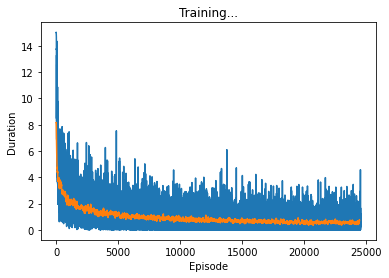

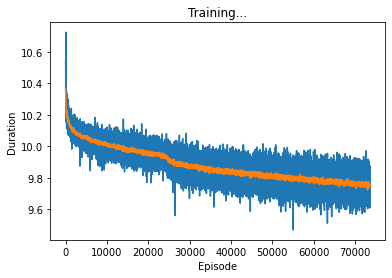

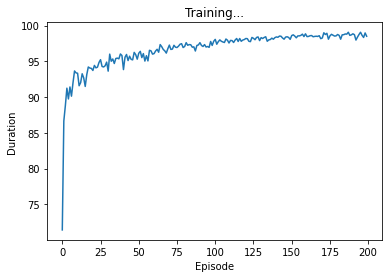

In [ ]:
# Plot learning curves
plt.figure(1)
durations_t = torch.tensor(loss_history, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(durations_t.numpy())
# Take 100 episode averages and plot them too
if len(durations_t) >= 50:
    means = durations_t.unfold(0, 50, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(9), means))
    plt.plot(means[50:].numpy())

plt.figure(2)
durations_t = torch.tensor(loss_hard_history, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(durations_t.numpy())
# Take 100 episode averages and plot them too
if len(durations_t) >= 50:
    means = durations_t.unfold(0, 50, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(9), means))
    plt.plot(means[50:].numpy())

plt.figure(3)
durations_t = torch.tensor(accruacy_history, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(durations_t.numpy())
# Take 100 episode averages and plot them too
if len(durations_t) >= 50:
    means = durations_t.unfold(0, 50, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(9), means))
    #plt.plot(means.numpy())

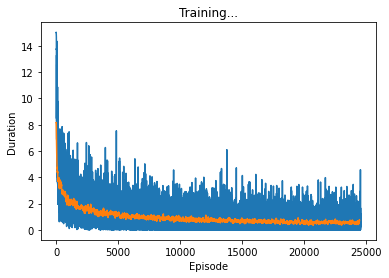

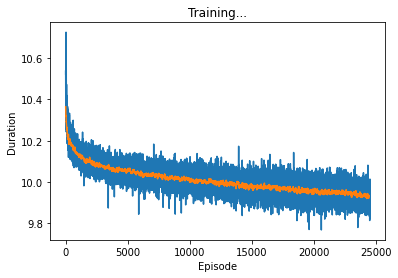

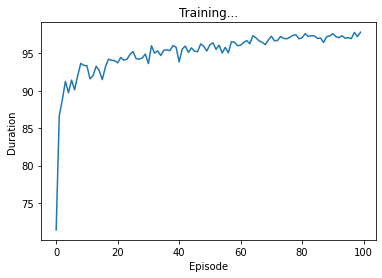

In [ ]:
# Plot learning curves
plt.figure(1)
durations_t = torch.tensor(loss_history, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(durations_t.numpy())
# Take 100 episode averages and plot them too
if len(durations_t) >= 50:
    means = durations_t.unfold(0, 50, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(9), means))
    plt.plot(means[50:].numpy())

plt.figure(2)
durations_t = torch.tensor(loss_hard_history, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(durations_t.numpy())
# Take 100 episode averages and plot them too
if len(durations_t) >= 50:
    means = durations_t.unfold(0, 50, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(9), means))
    plt.plot(means[50:].numpy())

plt.figure(3)
durations_t = torch.tensor(accruacy_history, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(durations_t.numpy())
# Take 100 episode averages and plot them too
if len(durations_t) >= 50:
    means = durations_t.unfold(0, 50, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(9), means))
    #plt.plot(means.numpy())

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

In [ ]:
for i, data in enumerate(test_dataloader,0):
    img0, img1 , img2, img3, _ = data

    x = torch.cat((img0, img1, img2, img3),0)
    x = x.cuda()
    embeddings = net(x)
    
    concatenated = torch.cat((img0,img1),0)
    euclidean_distance = F.pairwise_distance(embeddings[0:Config.test_batch_size],embeddings[Config.test_batch_size:Config.test_batch_size*2])
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
    print(True)
    concatenated = torch.cat((img0,img2),0)
    euclidean_distance = F.pairwise_distance(embeddings[0:Config.test_batch_size],embeddings[Config.test_batch_size*2:Config.test_batch_size*3])
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
    print(False)

    if i == 10:
      break



Output hidden; open in https://colab.research.google.com to view.